<a href="https://colab.research.google.com/github/kushal-jaat/ASD-assignment-3/blob/main/housing_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from google.colab import drive

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
import pandas as pd

# Mount Google Drive to access the datasets
from google.colab import drive
drive.mount('/content/drive')


rental_data = pd.read_csv('/content/drive/My Drive/housing/housing1.csv')

print("\nRental Data Sample:")
print(rental_data.head())



Mounted at /content/drive

Rental Data Sample:
           id                                                url  \
0  7049044568  https://reno.craigslist.org/apa/d/reno-beautif...   
1  7049047186  https://reno.craigslist.org/apa/d/reno-reduced...   
2  7043634882  https://reno.craigslist.org/apa/d/sparks-state...   
3  7049045324  https://reno.craigslist.org/apa/d/reno-1x1-fir...   
4  7049043759  https://reno.craigslist.org/apa/d/reno-no-long...   

         region                   region_url  price       type  sqfeet  beds  \
0  reno / tahoe  https://reno.craigslist.org   1148  apartment    1078     3   
1  reno / tahoe  https://reno.craigslist.org   1200      condo    1001     2   
2  reno / tahoe  https://reno.craigslist.org   1813  apartment    1683     2   
3  reno / tahoe  https://reno.craigslist.org   1095  apartment     708     1   
4  reno / tahoe  https://reno.craigslist.org    289  apartment     250     0   

   baths  cats_allowed  ...  wheelchair_access  electric_vehicl

In [ ]:
# Inspect the rental data structure
print("\nRental Data Information:")
rental_data.info()

print("\nRental Data Column Summary:")
print(rental_data.describe(include='all'))

print("\nRental Data Sample:")
print(rental_data.head())



Rental Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384977 entries, 0 to 384976
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       384977 non-null  int64  
 1   url                      384977 non-null  object 
 2   region                   384977 non-null  object 
 3   region_url               384977 non-null  object 
 4   price                    384977 non-null  int64  
 5   type                     384977 non-null  object 
 6   sqfeet                   384977 non-null  int64  
 7   beds                     384977 non-null  int64  
 8   baths                    384977 non-null  float64
 9   cats_allowed             384977 non-null  int64  
 10  dogs_allowed             384977 non-null  int64  
 11  smoking_allowed          384977 non-null  int64  
 12  wheelchair_access        384977 non-null  int64  
 13  electric_vehicle_charge  384977 n

In [ ]:
# Check missing values in the hosing dataset
print("Missing values in each column:")
print(rental_data.isnull().sum())


Missing values in each column:
id                              0
url                             0
region                          0
region_url                      0
price                           0
type                            0
sqfeet                          0
beds                            0
baths                           0
cats_allowed                    0
dogs_allowed                    0
smoking_allowed                 0
wheelchair_access               0
electric_vehicle_charge         0
comes_furnished                 0
laundry_options             79026
parking_options            140687
image_url                       0
description                     2
lat                          1918
long                         1918
state                           0
dtype: int64


In [ ]:
# Checking data types of each column
print("Data types of each column:")
print(rental_data.dtypes)


Data types of each column:
id                           int64
url                         object
region                      object
region_url                  object
price                        int64
type                        object
sqfeet                       int64
beds                         int64
baths                      float64
cats_allowed                 int64
dogs_allowed                 int64
smoking_allowed              int64
wheelchair_access            int64
electric_vehicle_charge      int64
comes_furnished              int64
laundry_options             object
parking_options             object
image_url                   object
description                 object
lat                        float64
long                       float64
state                       object
dtype: object


In [ ]:
# Check column names and shape
print("Columns in the dataset:")
print(rental_data.columns)
print(f"Shape of the dataset: {rental_data.shape}")


Columns in the dataset:
Index(['id', 'url', 'region', 'region_url', 'price', 'type', 'sqfeet', 'beds',
       'baths', 'cats_allowed', 'dogs_allowed', 'smoking_allowed',
       'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished',
       'laundry_options', 'parking_options', 'image_url', 'description', 'lat',
       'long', 'state'],
      dtype='object')
Shape of the dataset: (384977, 22)


In [ ]:
# Handle missing values for categorical columns  without inplace
rental_data['laundry_options'] = rental_data['laundry_options'].fillna(rental_data['laundry_options'].mode()[0])
rental_data['parking_options'] = rental_data['parking_options'].fillna(rental_data['parking_options'].mode()[0])

# Drop rows with missing description, lat, and long
rental_data = rental_data.dropna(subset=['description', 'lat', 'long'])

# Check if there are still missing values
print("Missing values after handling:")
print(rental_data.isnull().sum())

# Show the shape of the dataset after handling missing values
print("Shape after handling missing values:", rental_data.shape)


Missing values after handling:
id                         0
url                        0
region                     0
region_url                 0
price                      0
type                       0
sqfeet                     0
beds                       0
baths                      0
cats_allowed               0
dogs_allowed               0
smoking_allowed            0
wheelchair_access          0
electric_vehicle_charge    0
comes_furnished            0
laundry_options            0
parking_options            0
image_url                  0
description                0
lat                        0
long                       0
state                      0
dtype: int64
Shape after handling missing values: (383057, 22)


In [ ]:
# Select the columns for one-hot encoding
columns_to_encode = ['region', 'type', 'laundry_options', 'parking_options', 'state']

# Apply one-hot encoding
rental_data_encoded = pd.get_dummies(rental_data, columns=columns_to_encode, drop_first=True)

# Check the columns after encoding
print("Columns after One-Hot Encoding:")
print(rental_data_encoded.columns)

# Check the shape after encoding
print("Shape of dataset after One-Hot Encoding:", rental_data_encoded.shape)


Columns after One-Hot Encoding:
Index(['id', 'url', 'region_url', 'price', 'sqfeet', 'beds', 'baths',
       'cats_allowed', 'dogs_allowed', 'smoking_allowed',
       ...
       'state_sd', 'state_tn', 'state_tx', 'state_ut', 'state_va', 'state_vt',
       'state_wa', 'state_wi', 'state_wv', 'state_wy'],
      dtype='object', length=491)
Shape of dataset after One-Hot Encoding: (383057, 491)


In [ ]:
# Dropping unnecessary columns
columns_to_drop = ['id', 'url', 'region_url', 'image_url','description']
rental_data_encoded.drop(columns=columns_to_drop, inplace=True)

# Check the shape and first few rows after dropping the columns
print(f"Shape of dataset after dropping unnecessary columns: {rental_data_encoded.shape}")
print(rental_data_encoded.head())


Shape of dataset after dropping unnecessary columns: (383057, 486)
   price  sqfeet  beds  baths  cats_allowed  dogs_allowed  smoking_allowed  \
0   1148    1078     3    2.0             1             1                0   
1   1200    1001     2    2.0             0             0                0   
2   1813    1683     2    2.0             1             1                1   
3   1095     708     1    1.0             1             1                1   
4    289     250     0    1.0             1             1                1   

   wheelchair_access  electric_vehicle_charge  comes_furnished  ...  state_sd  \
0                  0                        0                0  ...     False   
1                  0                        0                0  ...     False   
2                  0                        0                0  ...     False   
3                  0                        0                0  ...     False   
4                  1                        0              

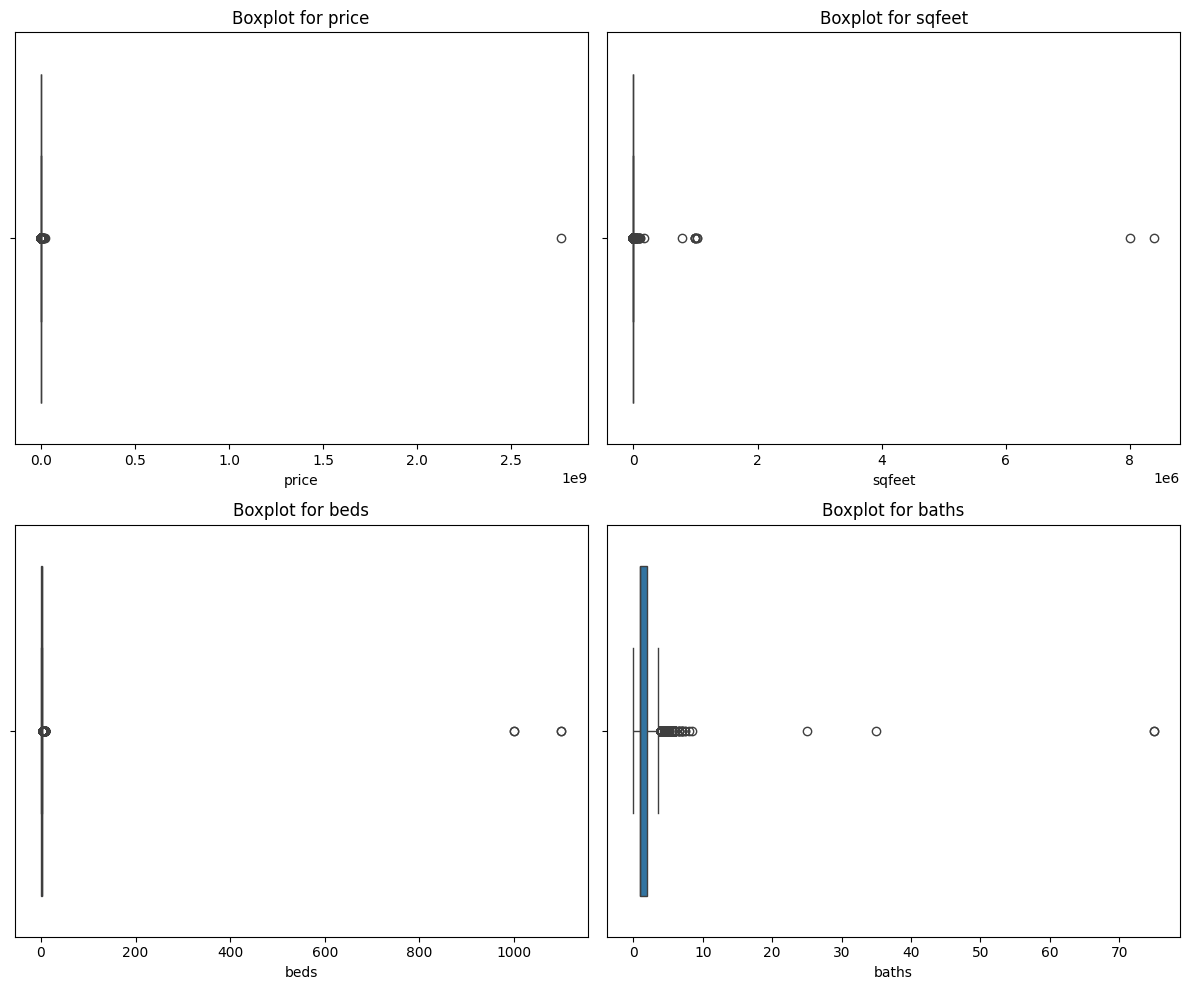

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numerical columns to check for outliers
numerical_columns = ['price', 'sqfeet', 'beds', 'baths']

# Plot boxplots to identify outliers
plt.figure(figsize=(12, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=rental_data_encoded[col])
    plt.title(f"Boxplot for {col}")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
# Reinitialize the cleaned dataset
rental_data_cleaned = rental_data_encoded.copy()

# List of columns to apply log transformation
columns_to_transform = ['price', 'sqfeet', 'beds', 'baths']

# Apply log transformation (adding 1 to avoid log(0))
for column in columns_to_transform:
    rental_data_cleaned[column + '_log'] = np.log1p(rental_data_cleaned[column])

# Check the transformed columns
print("Log-transformed columns preview:")
print(rental_data_cleaned[[col + '_log' for col in columns_to_transform]].head())

# Check the shape of the dataset
print("Shape of the dataset after log transformation:", rental_data_cleaned.shape)


Log-transformed columns preview:
   price_log  sqfeet_log  beds_log  baths_log
0   7.046647    6.983790  1.386294   1.098612
1   7.090910    6.909753  1.098612   1.098612
2   7.503290    7.428927  1.098612   1.098612
3   6.999422    6.563856  0.693147   0.693147
4   5.669881    5.525453  0.000000   0.693147
Shape of the dataset after log transformation: (383057, 490)


In [ ]:
# List of log-transformed columns to check for outliers
columns_to_filter = ['price_log', 'sqfeet_log', 'beds_log', 'baths_log']

# Remove outliers based on IQR
for col in columns_to_filter:
    Q1 = rental_data_cleaned[col].quantile(0.25)
    Q3 = rental_data_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    rental_data_cleaned = rental_data_cleaned[
        (rental_data_cleaned[col] >= lower_bound) & (rental_data_cleaned[col] <= upper_bound)
    ]

# Check the shape after removing outliers
print("Shape after removing outliers (IQR method):", rental_data_cleaned.shape)


Shape after removing outliers (IQR method): (351307, 490)


In [ ]:
columns_to_filter = ['price_log', 'sqfeet_log']
for col in columns_to_filter:
    Q1 = rental_data_cleaned[col].quantile(0.25)
    Q3 = rental_data_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR  # IQR lower bound
    upper_bound = Q3 + 1.5 * IQR  # IQR upper bound

    # Combine Z-score limits (3 standard deviations) with IQR limits
    mean = rental_data_cleaned[col].mean()
    std = rental_data_cleaned[col].std()
    z_lower_bound = mean - 3 * std
    z_upper_bound = mean + 3 * std

    # Take the stricter of the two methods
    final_lower_bound = max(lower_bound, z_lower_bound)
    final_upper_bound = min(upper_bound, z_upper_bound)

    # Remove rows outside the final bounds
    rental_data_cleaned = rental_data_cleaned[
        (rental_data_cleaned[col] >= final_lower_bound) &
        (rental_data_cleaned[col] <= final_upper_bound)
    ]

# Check the final shape of the dataset
print("Final dataset shape after removing persistent outliers:", rental_data_cleaned.shape)


Final dataset shape after removing persistent outliers: (348403, 490)


In [ ]:
# Remove the remaining outliers by setting absolute bounds
for col in ['price_log', 'sqfeet_log']:
    Q1 = rental_data_cleaned[col].quantile(0.25)
    Q3 = rental_data_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove all rows outside the IQR bounds
    rental_data_cleaned = rental_data_cleaned[
        (rental_data_cleaned[col] >= lower_bound) &
        (rental_data_cleaned[col] <= upper_bound)
    ]

# Verify the dataset shape
print("Final dataset shape after removing all outliers:", rental_data_cleaned.shape)


Final dataset shape after removing all outliers: (348162, 490)


In [ ]:
# Recalculate the number of outliers in the cleaned dataset
outliers_remaining = {}

for col in ['price_log', 'sqfeet_log', 'beds_log', 'baths_log']:
    Q1 = rental_data_cleaned[col].quantile(0.25)
    Q3 = rental_data_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count remaining outliers
    outliers_remaining[col] = ((rental_data_cleaned[col] < lower_bound) |
                               (rental_data_cleaned[col] > upper_bound)).sum()

# Display the number of remaining outliers
print("Number of outliers remaining in each column (IQR method):")
print(outliers_remaining)


Number of outliers remaining in each column (IQR method):
{'price_log': 0, 'sqfeet_log': 0, 'beds_log': 0, 'baths_log': 0}


In [ ]:
log_columns = ['price_log', 'sqfeet_log', 'beds_log', 'baths_log']


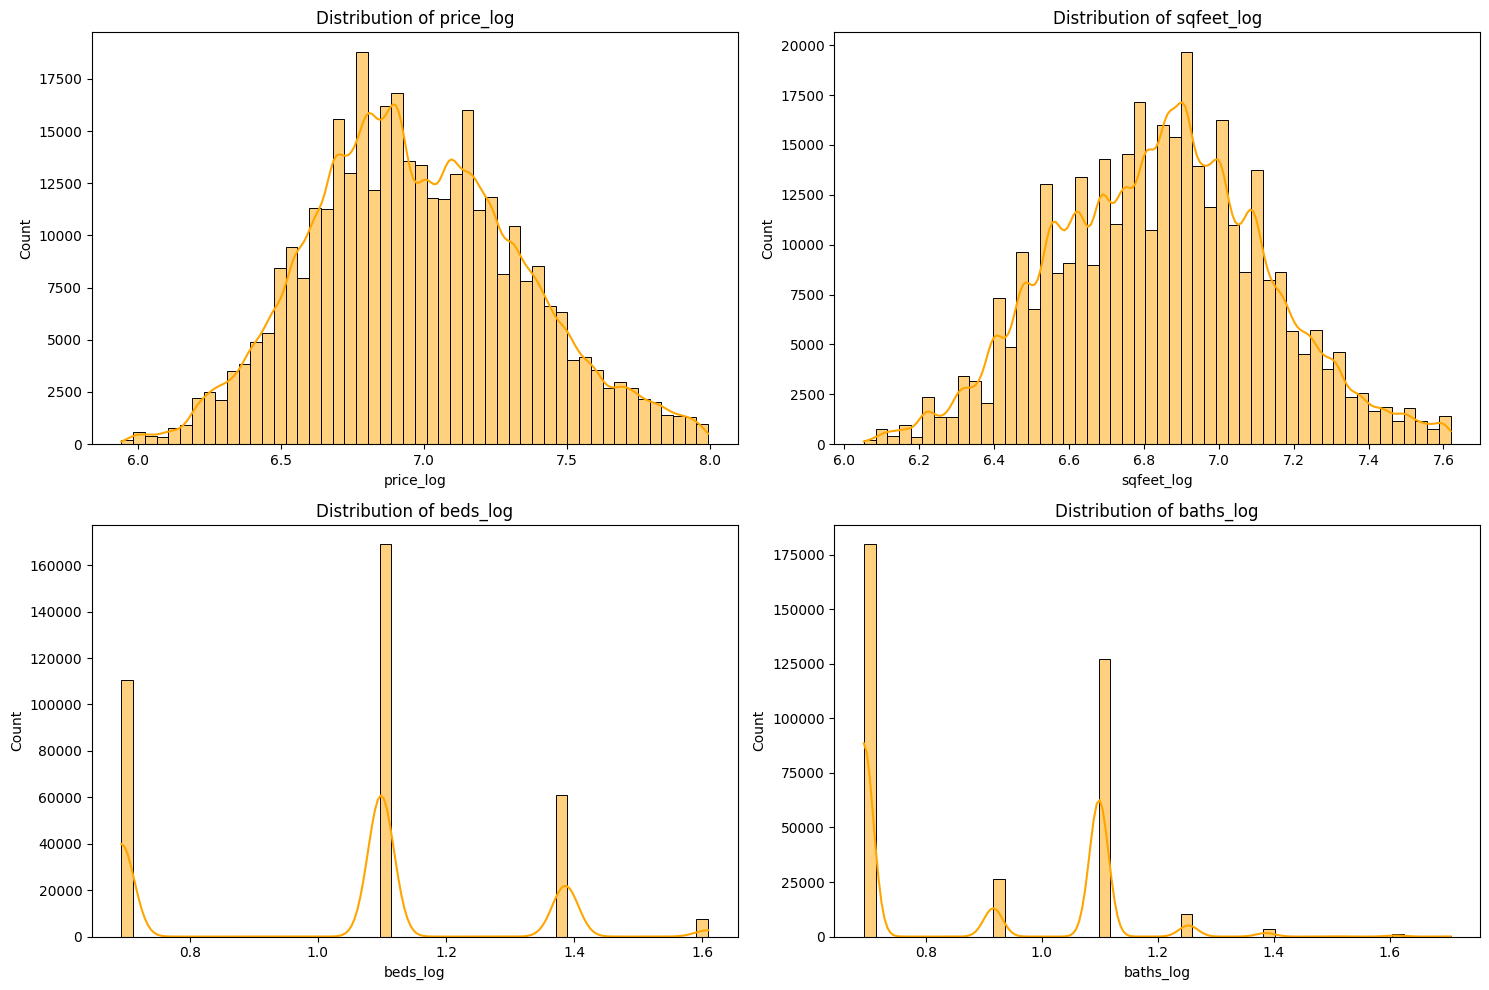

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms to show distributions
plt.figure(figsize=(15, 10))
for i, col in enumerate(log_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(rental_data_cleaned[col], kde=True, bins=50, color='orange')
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()



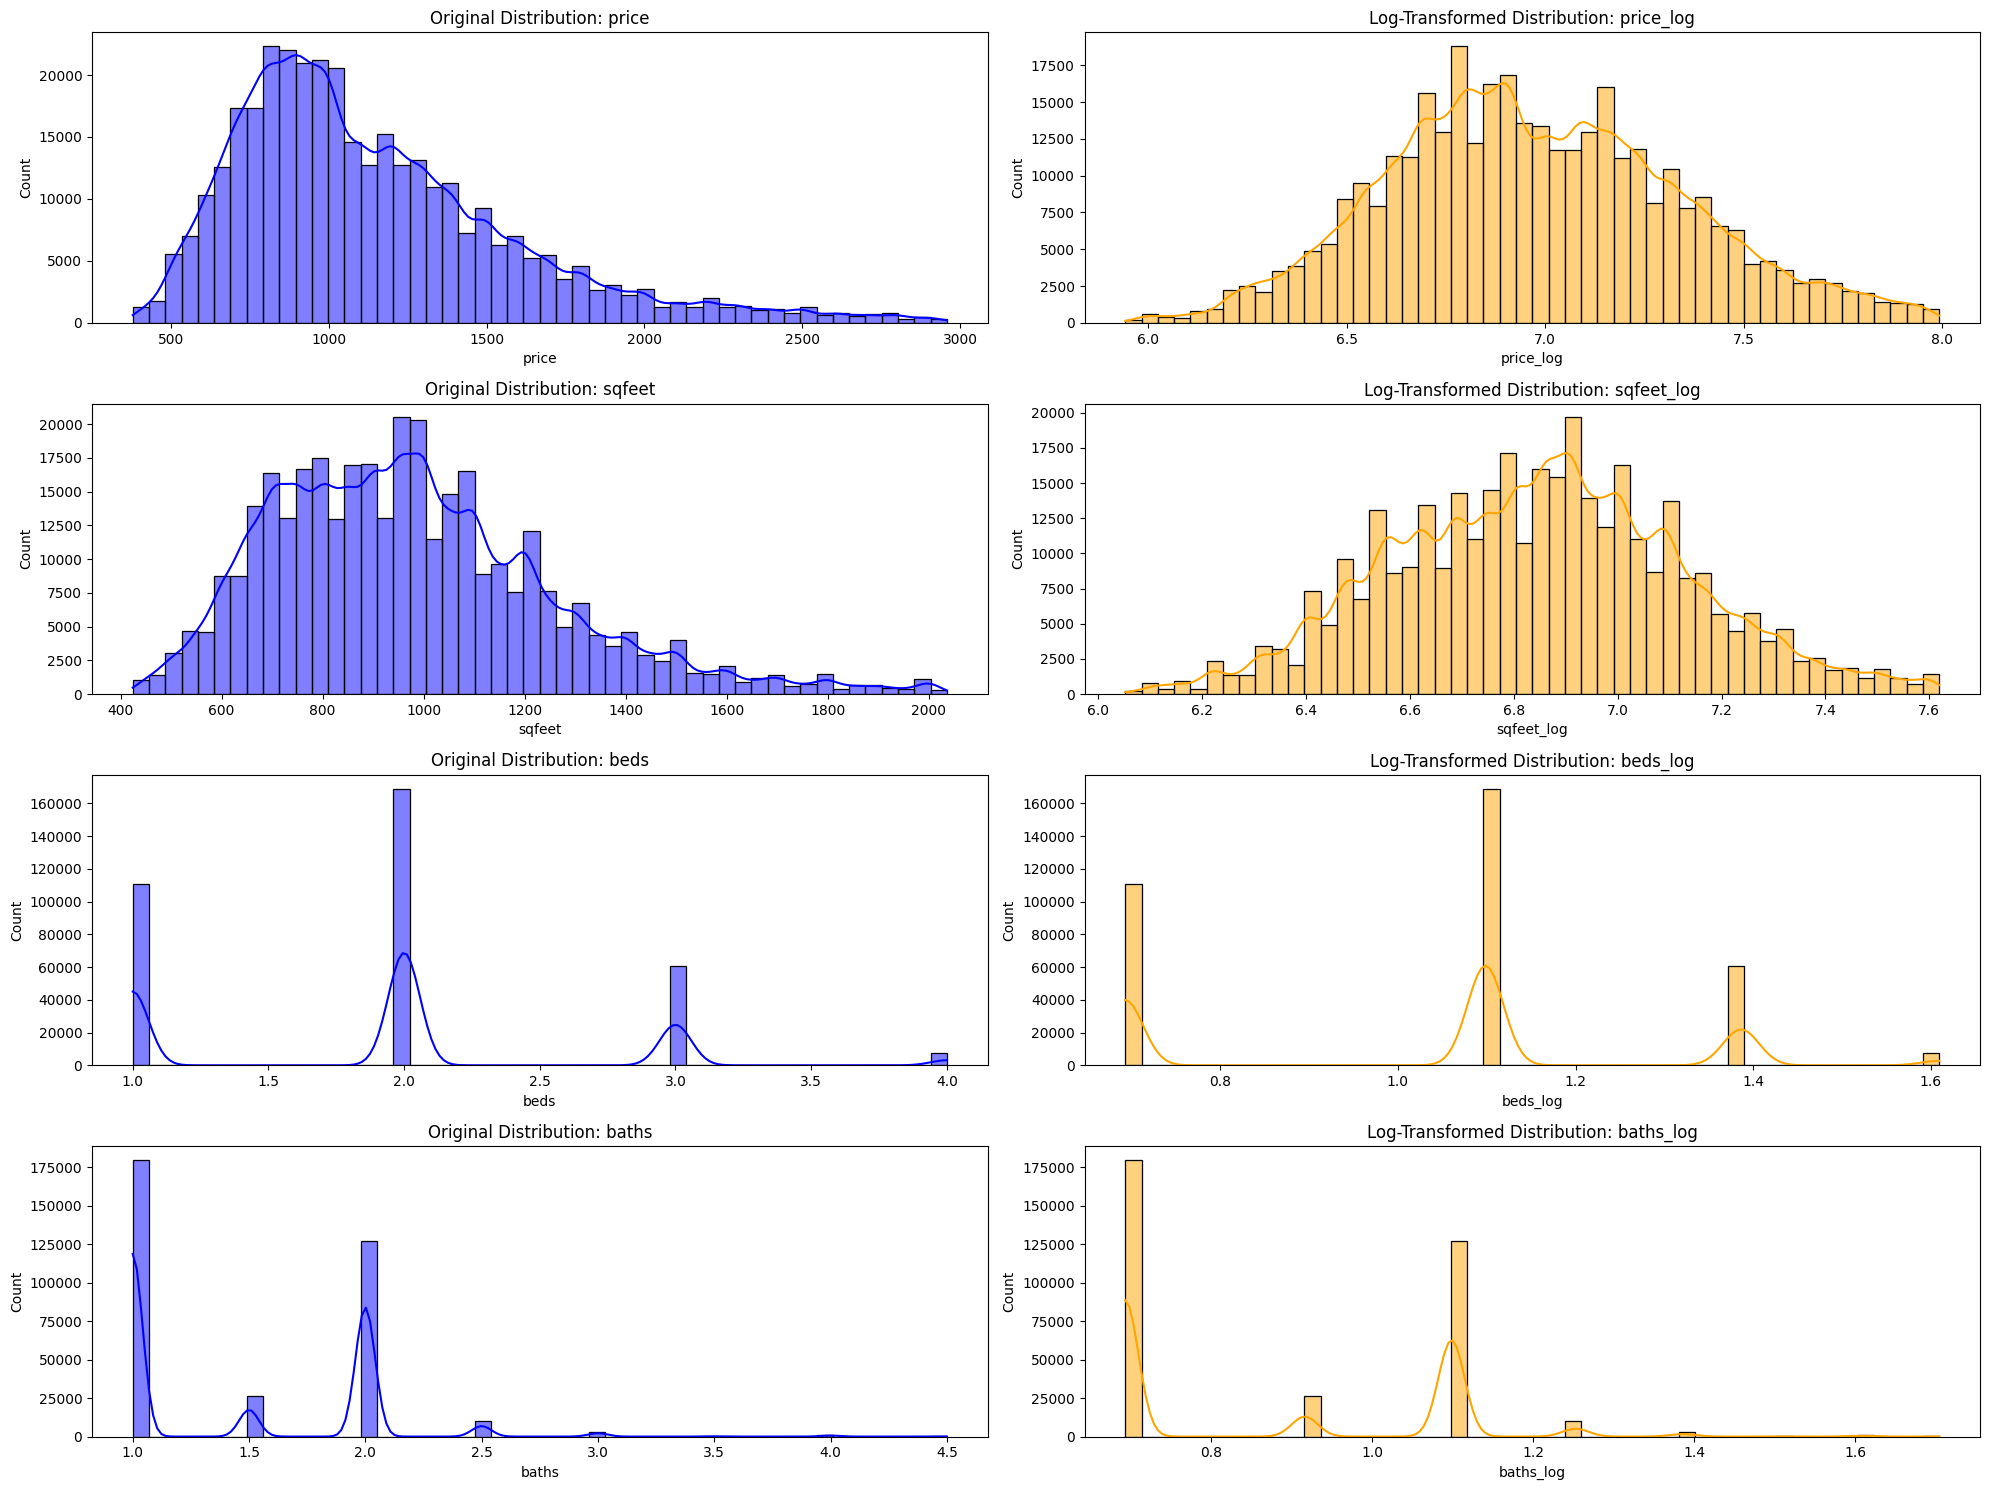

In [ ]:
# Compare original and log-transformed distributions
original_columns = ['price', 'sqfeet', 'beds', 'baths']

plt.figure(figsize=(20, 15))
for i, col in enumerate(original_columns, 1):
    # Original column
    plt.subplot(4, 2, 2 * i - 1)
    sns.histplot(rental_data_cleaned[col], kde=True, bins=50, color='blue')
    plt.title(f'Original Distribution: {col}')

    # Log-transformed column
    plt.subplot(4, 2, 2 * i)
    sns.histplot(rental_data_cleaned[col + '_log'], kde=True, bins=50, color='orange')
    plt.title(f'Log-Transformed Distribution: {col}_log')

plt.tight_layout()
plt.show()


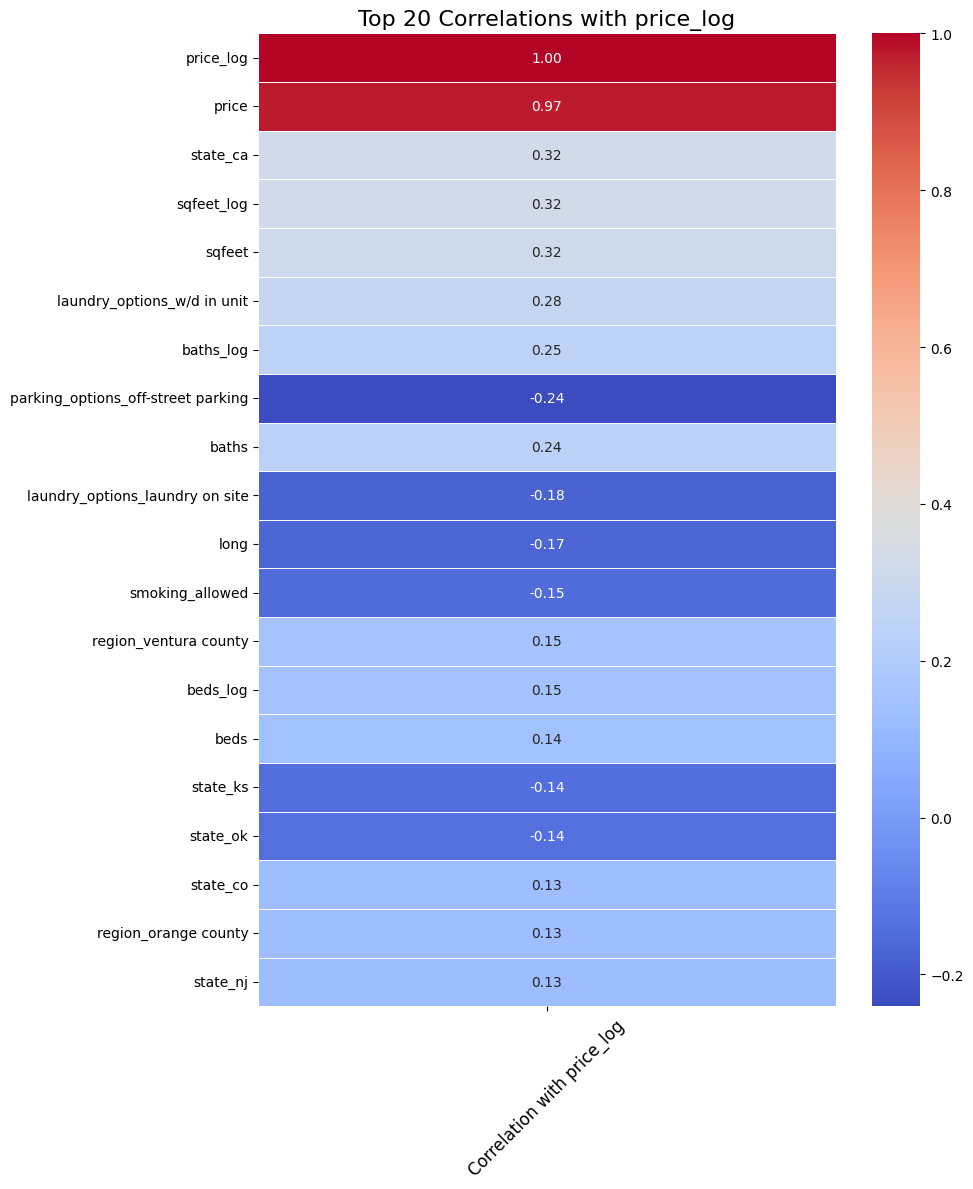

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlations for all columns with the target variable `price_log`
correlations = rental_data_cleaned.corr()['price_log'].dropna()

# Convert correlations to a DataFrame for better readability
correlation_df = correlations.to_frame(name='Correlation with price_log')
correlation_df['Absolute Correlation'] = correlation_df['Correlation with price_log'].abs()

# Sort correlations by absolute value and select the top 20
top_20_correlation = correlation_df.nlargest(20, 'Absolute Correlation')

# Create a heatmap for the top 20 correlations
plt.figure(figsize=(10, 12))
sns.heatmap(
    top_20_correlation[['Correlation with price_log']],
    annot=True,
    cmap='coolwarm',
    cbar=True,
    fmt='.2f',
    linewidths=0.5
)
plt.title("Top 20 Correlations with price_log", fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.feature_selection import VarianceThreshold
threshold = 0.01
selector = VarianceThreshold(threshold=threshold)
reduced_data = selector.fit_transform(rental_data_cleaned)

# Get the selected feature names
selected_features = rental_data_cleaned.columns[selector.get_support()]
print(f"Selected features after low-variance removal: {len(selected_features)}")
print(f"Selected features: {selected_features}")


Selected features after low-variance removal: 61
Selected features: Index(['price', 'sqfeet', 'beds', 'baths', 'cats_allowed', 'dogs_allowed',
       'smoking_allowed', 'wheelchair_access', 'electric_vehicle_charge',
       'comes_furnished', 'lat', 'long', 'region_jacksonville', 'type_condo',
       'type_duplex', 'type_house', 'type_manufactured', 'type_townhouse',
       'laundry_options_laundry on site', 'laundry_options_w/d hookups',
       'laundry_options_w/d in unit', 'parking_options_carport',
       'parking_options_detached garage', 'parking_options_off-street parking',
       'parking_options_street parking', 'state_al', 'state_az', 'state_ca',
       'state_co', 'state_fl', 'state_ga', 'state_ia', 'state_id', 'state_il',
       'state_in', 'state_ks', 'state_ky', 'state_la', 'state_ma', 'state_md',
       'state_mi', 'state_mn', 'state_ms', 'state_nc', 'state_nj', 'state_ny',
       'state_oh', 'state_ok', 'state_or', 'state_pa', 'state_sc', 'state_tn',
       'state_tx', 

In [ ]:
# Specify the columns to drop
columns_to_drop = ['price', 'beds', 'baths', 'sqfeet']

# Drop the columns from the dataset
rental_data_cleaned = rental_data_cleaned.drop(columns=columns_to_drop)

# Display the updated DataFrame
print("Remaining columns after dropping:", rental_data_cleaned.columns)


Remaining columns after dropping: Index(['cats_allowed', 'dogs_allowed', 'smoking_allowed', 'wheelchair_access',
       'electric_vehicle_charge', 'comes_furnished', 'lat', 'long',
       'region_abilene', 'region_akron / canton',
       ...
       'state_va', 'state_vt', 'state_wa', 'state_wi', 'state_wv', 'state_wy',
       'price_log', 'sqfeet_log', 'beds_log', 'baths_log'],
      dtype='object', length=486)


In [ ]:
# Define features and target
# Since 'price' is already dropped, we focus on dropping 'price_log' for features
if 'price_log' in rental_data_cleaned.columns:
    rental_X = rental_data_cleaned.drop(columns=['price_log'])  # Features only
    rental_y = rental_data_cleaned['price_log']  # Target variable
else:
    print("'price_log' is not found in the dataset!")

# Verify all remaining columns are numeric or boolean
non_numeric_columns = rental_X.select_dtypes(exclude=['number', 'bool']).columns
if len(non_numeric_columns) == 0:
    print("All columns in the rental dataset are numeric or boolean.")
else:
    print(f"Non-numeric columns remain: {non_numeric_columns.tolist()}")

# Convert all columns to numeric (if not done automatically)
rental_X = rental_X.astype(float)
print("Converted all feature columns to float.")


All columns in the rental dataset are numeric or boolean.
Converted all feature columns to float.


In [ ]:
from sklearn.model_selection import train_test_split

# rental_X = rental_data_cleaned.drop(columns=['price_log'])  # Features only
# rental_y = rental_data_cleaned['price_log']  # Target

# Perform train-test split for Rental Dataset
rental_X_train, rental_X_test, rental_y_train, rental_y_test = train_test_split(
    rental_X, rental_y, test_size=0.2, random_state=42
)

# Display the shapes of the splits
print("\nData Split Summary:")
print(f"Rental Dataset - Training Features: {rental_X_train.shape}, Testing Features: {rental_X_test.shape}")
print(f"Rental Dataset - Training Target: {rental_y_train.shape}, Testing Target: {rental_y_test.shape}")



Data Split Summary:
Rental Dataset - Training Features: (278529, 485), Testing Features: (69633, 485)
Rental Dataset - Training Target: (278529,), Testing Target: (69633,)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as npzz

# Function to train and evaluate a baseline model
def baseline_model(X_train, X_test, y_train, y_test, dataset_name):
    print(f"Evaluating Baseline Model for {dataset_name}...\n")

    # Initialize and train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Print metrics
    print(f"{dataset_name} Metrics:")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R² Score: {r2:.4f}")
    print("-" * 30)

    return model, y_pred

# Baseline model for Rental Dataset
rental_model, rental_y_pred = baseline_model(rental_X_train, rental_X_test, rental_y_train, rental_y_test, "Rental Dataset")


Evaluating Baseline Model for Rental Dataset...

Rental Dataset Metrics:
  MAE: 0.1467
  RMSE: 0.2062
  R² Score: 0.6919
------------------------------


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Function to train, evaluate, and analyze feature importance
def random_forest_model(X_train, X_test, y_train, y_test, dataset_name):
    print(f"Evaluating Random Forest Model for {dataset_name}...\n")

    # Initialize and train the model
    model = RandomForestRegressor(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Print metrics
    print(f"{dataset_name} Metrics:")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R² Score: {r2:.4f}")
    print("-" * 30)

    return model, y_pred

# Apply the Random Forest model to the Rental Dataset
rental_rf_model, rental_rf_pred = random_forest_model(rental_X_train, rental_X_test, rental_y_train, rental_y_test, "Rental Dataset")


Evaluating Random Forest Model for Rental Dataset...

Rental Dataset Metrics:
  MAE: 0.0524
  RMSE: 0.1108
  R² Score: 0.9111
------------------------------


First 20 Predictions with Differences:
        Original Price  Prediction Value  Difference (Gap)
271088           755.0        818.376928     -6.337693e+01
124502          1020.0       1116.485951     -9.648595e+01
94918           1430.0       1435.992937     -5.992937e+00
365663           655.0        683.867596     -2.886760e+01
333722           984.0        972.074575      1.192543e+01
19657           1512.0       1490.653231      2.134677e+01
289372           735.0        730.619572      4.380428e+00
190118          1190.0       1212.775533     -2.277553e+01
194188          1025.0       1020.932420      4.067580e+00
36630            960.0        960.000000     -9.094947e-13
56422            970.0        971.390456     -1.390456e+00
10398           1653.0       1775.648311     -1.226483e+02
207655           450.0        574.073787     -1.240738e+02
302723           545.0        584.204315     -3.920431e+01
282786           815.0        923.743755     -1.087438e+02
189033          1

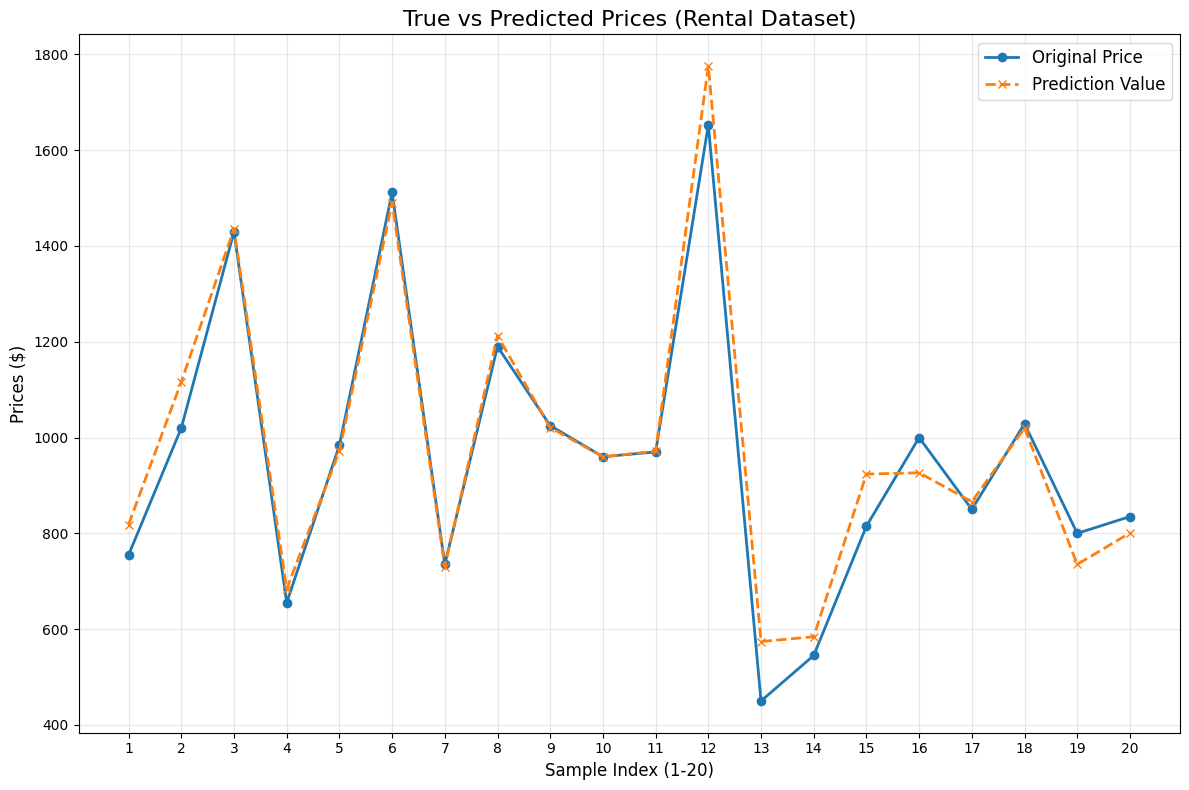

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate predictions for the test set
y_pred = rental_rf_model.predict(rental_X_test)

# Create a DataFrame for the first 20 predictions
predictions_df = pd.DataFrame({
    "Log True Values": rental_y_test[:20],  # Log-transformed true values
    "Log Predicted Values": y_pred[:20]    # Log-transformed predicted values
})

# Convert log-transformed values back to original prices
predictions_df["Original Price"] = np.expm1(predictions_df["Log True Values"])
predictions_df["Prediction Value"] = np.expm1(predictions_df["Log Predicted Values"])

# Calculate the gap between true and predicted prices
predictions_df["Difference (Gap)"] = predictions_df["Original Price"] - predictions_df["Prediction Value"]

# Print the updated DataFrame
print("First 20 Predictions with Differences:")
print(predictions_df[["Original Price", "Prediction Value", "Difference (Gap)"]])

# Plot True vs Predicted Prices
plt.figure(figsize=(12, 8))
plt.plot(range(1, 21), predictions_df["Original Price"], label="Original Price", marker='o', linestyle='-', linewidth=2)
plt.plot(range(1, 21), predictions_df["Prediction Value"], label="Prediction Value", marker='x', linestyle='--', linewidth=2)
plt.title("True vs Predicted Prices (Rental Dataset)", fontsize=16)
plt.xlabel("Sample Index (1-20)", fontsize=12)
plt.ylabel("Prices ($)", fontsize=12)
plt.xticks(range(1, 21))
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Initialize scalers
# standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# # Apply Standard Scaling
# rental_X_train_scaled_standard = standard_scaler.fit_transform(rental_X_train)
# rental_X_test_scaled_standard = standard_scaler.transform(rental_X_test)

# Apply MinMax Scaling
rental_X_train_scaled_minmax = minmax_scaler.fit_transform(rental_X_train)
rental_X_test_scaled_minmax = minmax_scaler.transform(rental_X_test)

# Print shapes to confirm scaling was applied
# print("Standard Scaled Train Shape:", rental_X_train_scaled_standard.shape)
# print("Standard Scaled Test Shape:", rental_X_test_scaled_standard.shape)
print("MinMax Scaled Train Shape:", rental_X_train_scaled_minmax.shape)
print("MinMax Scaled Test Shape:", rental_X_test_scaled_minmax.shape)


Standard Scaled Train Shape: (278529, 485)
Standard Scaled Test Shape: (69633, 485)
MinMax Scaled Train Shape: (278529, 485)
MinMax Scaled Test Shape: (69633, 485)


Training Advanced Neural Network for Rental Dataset...



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
3482/3482 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 9.3489 - mae: 2.0172 - val_loss: 0.0582 - val_mae: 0.1749 - learning_rate: 0.0010
Epoch 2/100
3482/3482 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.2807 - mae: 0.4129 - val_loss: 0.0456 - val_mae: 0.1575 - learning_rate: 0.0010
Epoch 3/100
3482/3482 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1896 - mae: 0.3446 - val_loss: 0.0409 - val_mae: 0.1484 - learning_rate: 0.0010
Epoch 4/100
3482/3482 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1416 - mae: 0.2968 - val_loss: 0.0389 - val_mae: 0.1451 - learning_rate: 0.0010
Epoch 5/100
3482/3482 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1084 - mae: 0.2589 - val_loss: 0.0332 - val_mae: 0.1314 - learning_rate: 0.0010
Epoch 6/100
3482/3482 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0826 - mae: 0.2246 - val_loss: 0.0318 - val_mae: 0.1272 - learning_rate: 0.0010
Epoch 7/100
3482/3482 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0649 - mae: 0.1975 - val_loss: 0.0308 - val_mae: 0.1259 - learni

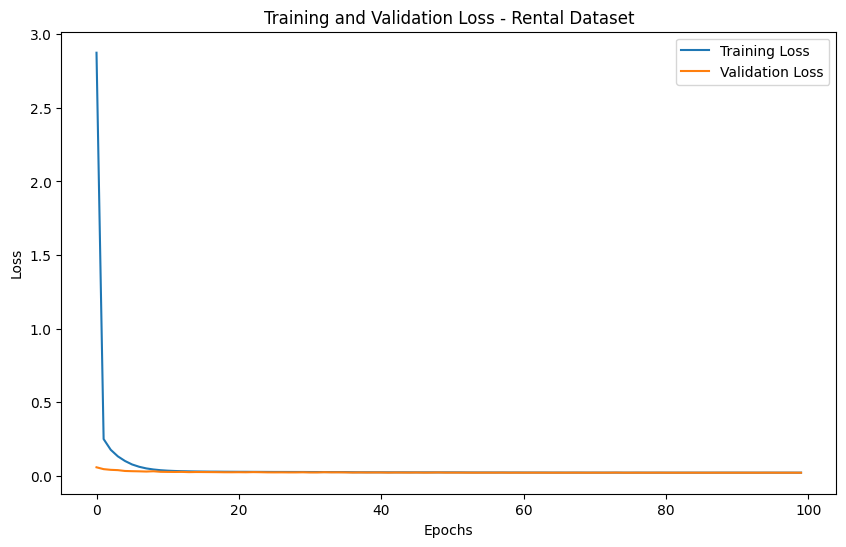

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Function to build, train, and evaluate a neural network
def advanced_neural_network(X_train, X_test, y_train, y_test, dataset_name, epochs=100, batch_size=64):
    print(f"Training Advanced Neural Network for {dataset_name}...\n")

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Build the neural network
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1)])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    # Callbacks for early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

    # Train the model
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stopping, reduce_lr]
    )

    # Evaluate the model on the test set
    y_pred = model.predict(X_test_scaled).flatten()
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Print metrics
    print(f"{dataset_name} Metrics:")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R² Score: {r2:.4f}")
    print("-" * 30)

    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss - {dataset_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model, y_pred

# Apply the updated neural network to the Rental Dataset
rental_advanced_nn_model, rental_nn_pred = advanced_neural_network
    (rental_X_train, rental_X_test, rental_y_train, rental_y_test, "Rental Dataset", epochs=100, batch_size=64)


First 20 Predictions with Original Prices:
    True Values  Predicted Values  Original True Values  \
0      6.628041          6.658060                 755.0   
1      6.928538          6.970313                1020.0   
2      7.266129          7.284338                1430.0   
3      6.486161          6.544117                 655.0   
4      6.892642          6.873827                 984.0   
5      7.321850          7.299922                1512.0   
6      6.601230          6.647383                 735.0   
7      7.082549          7.126410                1190.0   
8      6.933423          7.095094                1025.0   
9      6.867974          6.925467                 960.0   
10     6.878326          7.021334                 970.0   
11     7.410952          7.494149                1653.0   
12     6.111467          6.179603                 450.0   
13     6.302619          6.460134                 545.0   
14     6.704414          7.087759                 815.0   
15     6.9087

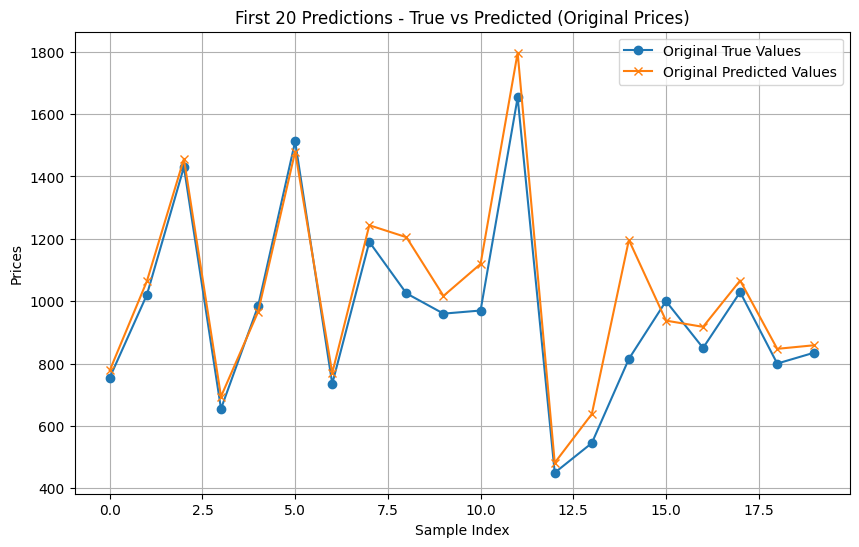

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create DataFrame for predictions
predictions_df = pd.DataFrame({
    "True Values": rental_y_test[:20].values,  # First 20 true values from the test set
    "Predicted Values": rental_nn_pred[:20]   # First 20 predicted values from the model
})

# Inverse transform the log values back to original prices
predictions_df["Original True Values"] = np.expm1(predictions_df["True Values"])
predictions_df["Original Predicted Values"] = np.expm1(predictions_df["Predicted Values"])
# Calculate the absolute difference between true and predicted prices
predictions_df["Difference"] = abs(predictions_df["Original True Values"] - predictions_df["Original Predicted Values"])
# Display the updated DataFrame with original prices
print("First 20 Predictions with Original Prices:")
print(predictions_df)

# Visualize the original prices
plt.figure(figsize=(10, 6))
plt.plot(predictions_df["Original True Values"], label="Original True Values", marker='o')
plt.plot(predictions_df["Original Predicted Values"], label="Original Predicted Values", marker='x')
plt.title("First 20 Predictions - True vs Predicted (Original Prices)")
plt.xlabel("Sample Index")
plt.ylabel("Prices")
plt.legend()
plt.grid()
plt.show()


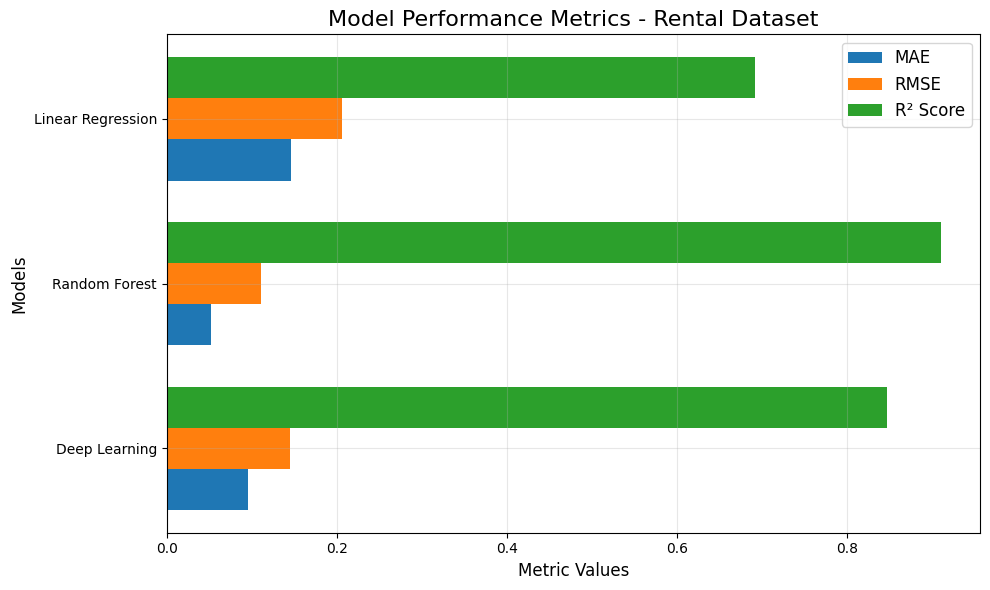

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for the Rental Dataset
models = ["Deep Learning", "Random Forest", "Linear Regression"]
mae_values = [0.0951, 0.0524, 0.1467]
rmse_values = [0.1451, 0.1108, 0.2062]
r2_values = [0.8474, 0.9111, 0.6919]

x = np.arange(len(models))  # The label locations
width = 0.25  # Width of the bars

# Plot MAE, RMSE, and R² as separate bars
plt.figure(figsize=(10, 6))
bar_width = 0.25
y = np.arange(len(models))

plt.barh(y - bar_width, mae_values, bar_width, label="MAE")
plt.barh(y, rmse_values, bar_width, label="RMSE")
plt.barh(y + bar_width, r2_values, bar_width, label="R² Score")

plt.title("Model Performance Metrics - Rental Dataset", fontsize=16)
plt.xlabel("Metric Values", fontsize=12)
plt.ylabel("Models", fontsize=12)
plt.yticks(y, models)
plt.legend(fontsize=12)
plt.tight_layout()
plt.grid(alpha=0.3)
plt.show()

